# Project data onto Niki Landscape
## Xiaonan Wang
## 21Apr2020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

2020-04-24 18:24:22,700 [161229] WARNING  py.warnings:110: [JupyterRequire] /usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex



scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.0 python-igraph==0.8.0 louvain==0.6.1


In [2]:
adata = sc.read('./write/Patel_processed_regressout_cellcycle.h5ad')

In [3]:
# match it to niki data, norm without log
adata = anndata.AnnData(X=np.exp(adata.raw.X.todense())-1, obs=adata.obs, var=adata.raw.var, obsm=adata.obsm)

In [4]:
niki_data = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/niki_passQC_norm_10K.h5ad')

In [5]:
niki_hvg = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Files/Niki_10X_data/WT_10X_data/gene_names.txt', dtype=str)

In [6]:
OLG = np.intersect1d(niki_hvg, adata.var_names)
print(len(OLG))
adata = adata[:,OLG].copy()
niki_data = niki_data[:,OLG].copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
sc.pp.normalize_per_cell(niki_data, counts_per_cell_after=10000)

sc.pp.log1p(adata)
sc.pp.log1p(niki_data)

4497
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [7]:
print(adata.shape)
print(niki_data.shape)

(24599, 4497)
(44802, 4497)


In [8]:
# scale them together
data_comb = adata.concatenate(niki_data)
sc.pp.scale(data_comb)

In [9]:
adata = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '0',:].X, obs=adata.obs, var=adata.var, obsm=adata.obsm, uns=adata.uns)
niki_data = anndata.AnnData(X=data_comb[data_comb.obs['batch'] == '1',:].X, obs=niki_data.obs, var=niki_data.var, obsm=niki_data.obsm, uns=niki_data.uns)

In [10]:
print(adata.shape)
print(niki_data.shape)

(24599, 4497)
(44802, 4497)


In [11]:
from sklearn.decomposition import PCA
pca_ = PCA(n_components=50, svd_solver='auto', random_state=0)

In [12]:
pca_.fit(niki_data.X)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=0,
    svd_solver='auto', tol=0.0, whiten=False)

In [13]:
X_pca1 = pca_.transform(niki_data.X)
X_pca2 = pca_.transform(adata.X)

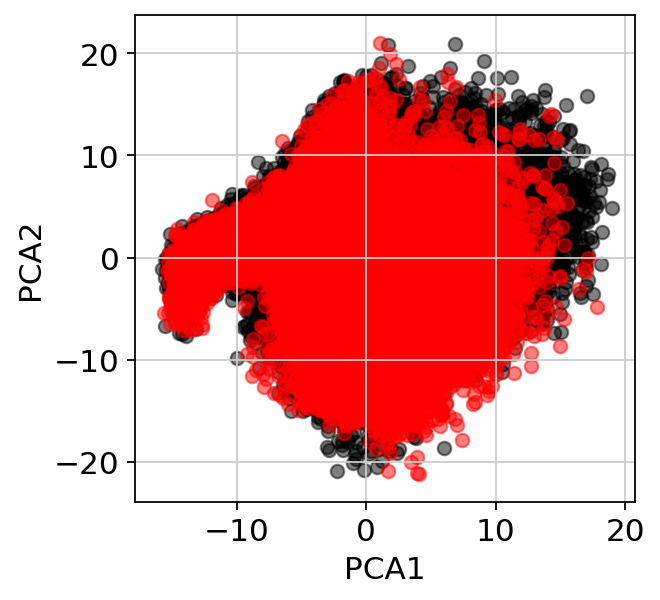

In [14]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(X_pca1[:,0], X_pca1[:,1], c='black', alpha=0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax1.scatter(X_pca2[:,0], X_pca2[:,1], c='red', alpha=0.5)
plt.show()

In [15]:
from sklearn.metrics.pairwise import euclidean_distances
D_sub = euclidean_distances(X_pca2, X_pca1)

In [16]:
print(X_pca1.shape)
print(X_pca2.shape)
print(D_sub.shape)

(44802, 50)
(24599, 50)
(24599, 44802)


In [48]:
from collections import Counter
from collections import defaultdict
cl_assigned = []
Rstore = defaultdict(list) # dictionary to store results
for i in range(D_sub.shape[0]):
    CellDis = D_sub[i,:]
    CellDis_sorted = np.argsort(CellDis)[:15]
    max_samples = niki_data.obs_names[CellDis_sorted]
    cl_assigned.append(max_samples)
    Rstore['MinDist'].append(np.min(CellDis[CellDis_sorted]))
    Rstore['MedianDist'].append(np.median(CellDis[CellDis_sorted]))
    Rstore['MaxDist'].append(np.max(CellDis[CellDis_sorted]))
    Rstore['SD'].append(np.std(CellDis[CellDis_sorted]))
    Rstore['Niki_CT'].append(Counter(niki_data.obs['CellSubType'][CellDis_sorted]).most_common(1)[0][0])
Rstore = pd.DataFrame.from_dict(Rstore)
Rstore.index = adata.obs_names

In [57]:
Rstore.head(3)

,MinDist,MedianDist,MaxDist,SD,Niki_CT
AAACCTGAGGTAAACT-1-0,8.036368,8.673485,8.925051,0.275853,Neutrop
AAACCTGCACCATGTA-1-0,5.195676,5.649943,5.958251,0.236640,Late er
AAACCTGCACCGATAT-1-0,12.087921,14.826504,15.638212,0.908511,Early e


In [18]:
def Obs_sublabels(ref_data, proj_data, proj_data_obs, cl_assigned, prefix):
    CT = np.unique(proj_data.obs[proj_data_obs])
    print(CT)
    for ct in CT:
        cl_assigned_sub = [cl_assigned[i] for i in np.where(proj_data.obs[proj_data_obs] == ct)[0]]
        cl_flat_sub = [item for sublist in cl_assigned_sub for item in sublist]
        freq1 = Counter(cl_flat_sub)
        freq2 = np.array([0] * ref_data.X.shape[0])
        for k, i in freq1.items():
            if k in ref_data.obs_names:
                idx = np.where(ref_data.obs_names==k)
                freq2[idx] = i
        ref_data.obs[prefix+'_'+ct] = np.log2(freq2+1)

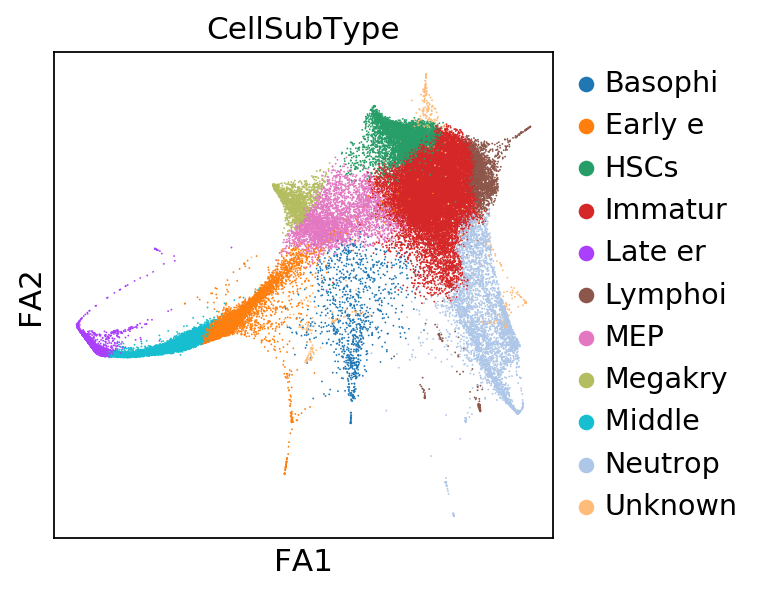

In [19]:
sc.pl.draw_graph(niki_data, color='CellSubType', legend_loc="right margin", color_map=cmap)

In [32]:
Obs_sublabels(niki_data, adata, 'louvain_v2', cl_assigned, 'SubLC')

['1' '10' '11' '12' '13' '2' '3' '4' '5' '6' '7' '8' '9']


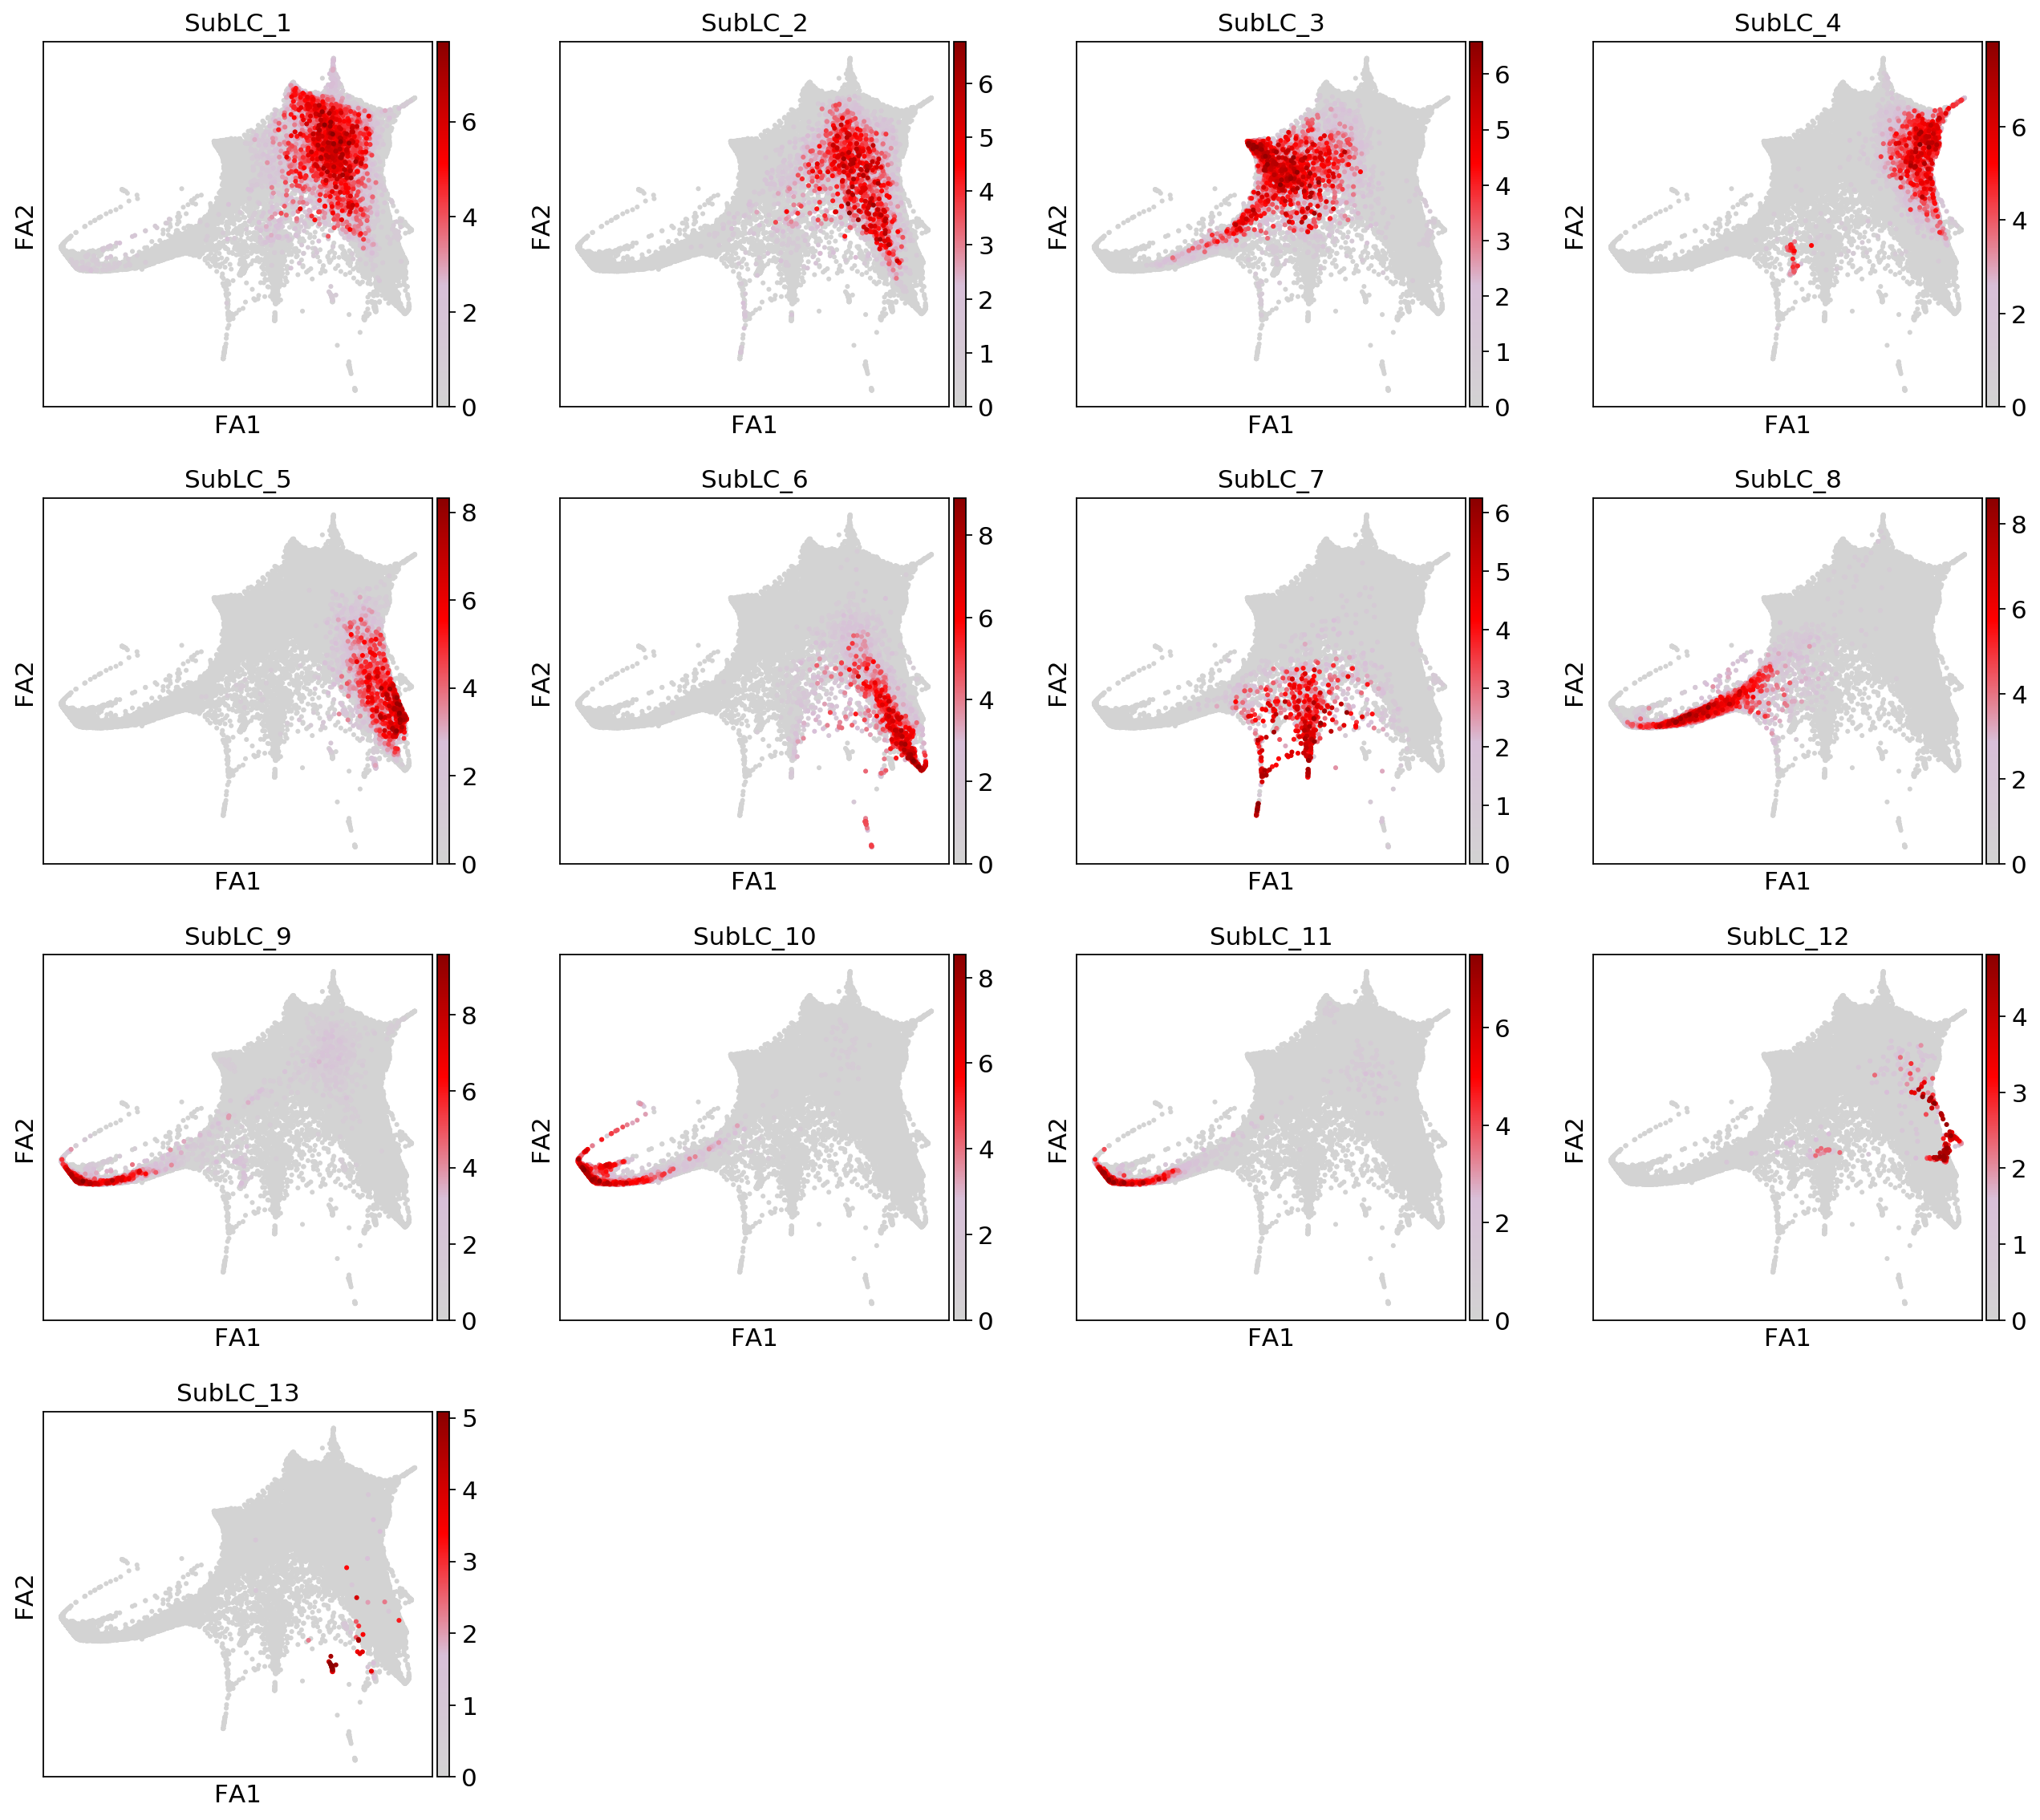

In [33]:
sc.pl.draw_graph(niki_data, color=['SubLC_'+x for x in adata.obs['louvain_v2'].cat.categories], legend_loc="right margin", color_map=cmap, size=30)

In [52]:
for i in adata.obs['louvain_v2'].cat.categories:
    #print(Counter(np.array(cl_assigned_ct)[adata.obs['louvain_v2'] == i]))
    ct = Counter(np.array(Rstore['Niki_CT'])[adata.obs['louvain_v2'] == i]).most_common(1)[0][0]
    print(i+':'+ct)

1:Immatur
2:Immatur
3:MEP
4:Lymphoi
5:Neutrop
6:Neutrop
7:Basophi
8:Middle 
9:Late er
10:Late er
11:Late er
12:Unknown
13:Lymphoi


In [24]:
Obs_sublabels(niki_data, adata, 'Condition', cl_assigned, 'SubCon')

['Aldh2/Fancd2 homo' 'Aldh2/Fancd2/p53 homo' 'WT']


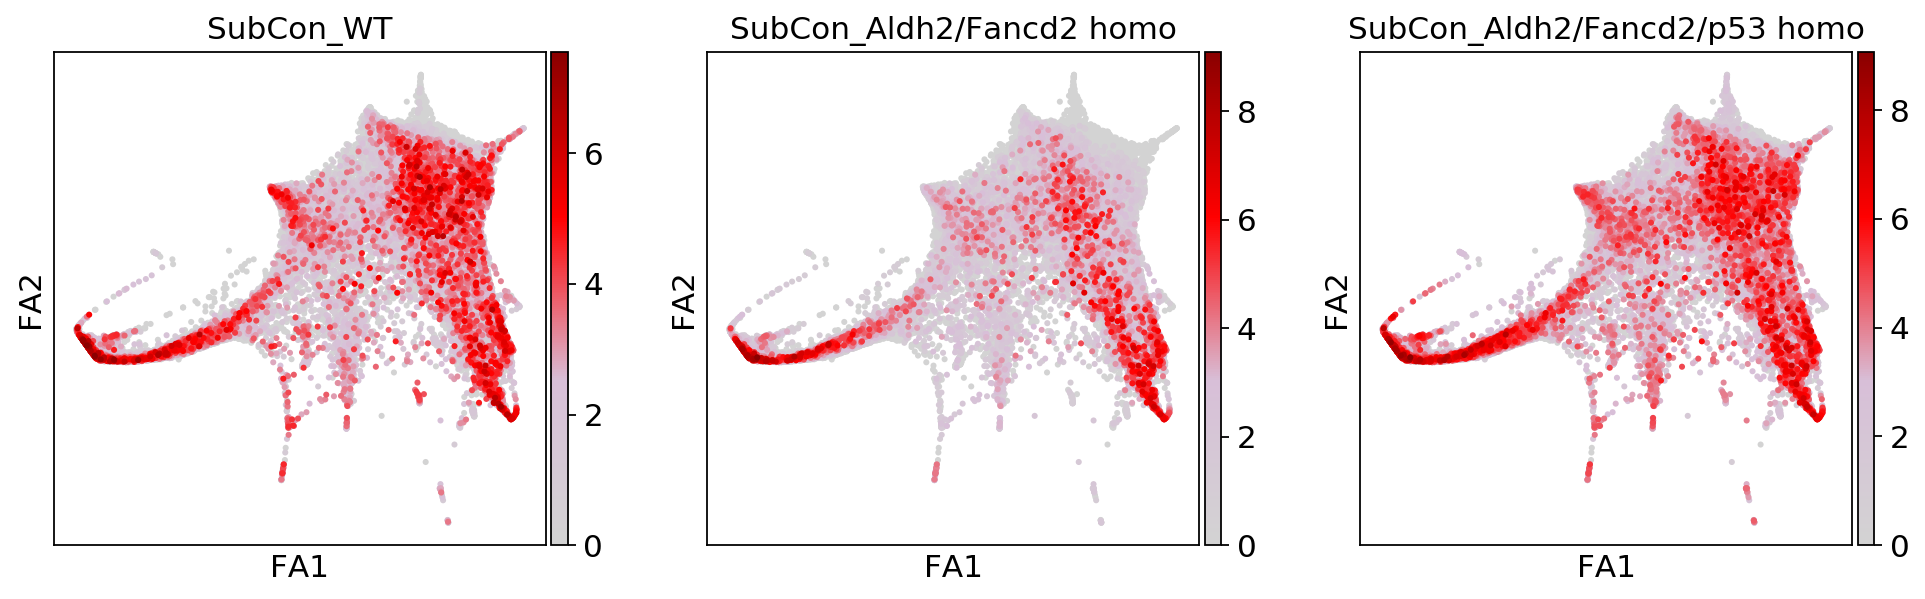

In [25]:
sc.pl.draw_graph(niki_data, color=['SubCon_'+x for x in adata.obs['Condition'].cat.categories], legend_loc="right margin", color_map=cmap, size=30)

In [59]:
adata.obs['Cell_assigned'] = Rstore['Niki_CT']

In [60]:
tab1 = pd.crosstab(adata.obs['Condition'],adata.obs['Cell_assigned'], normalize=0)*100

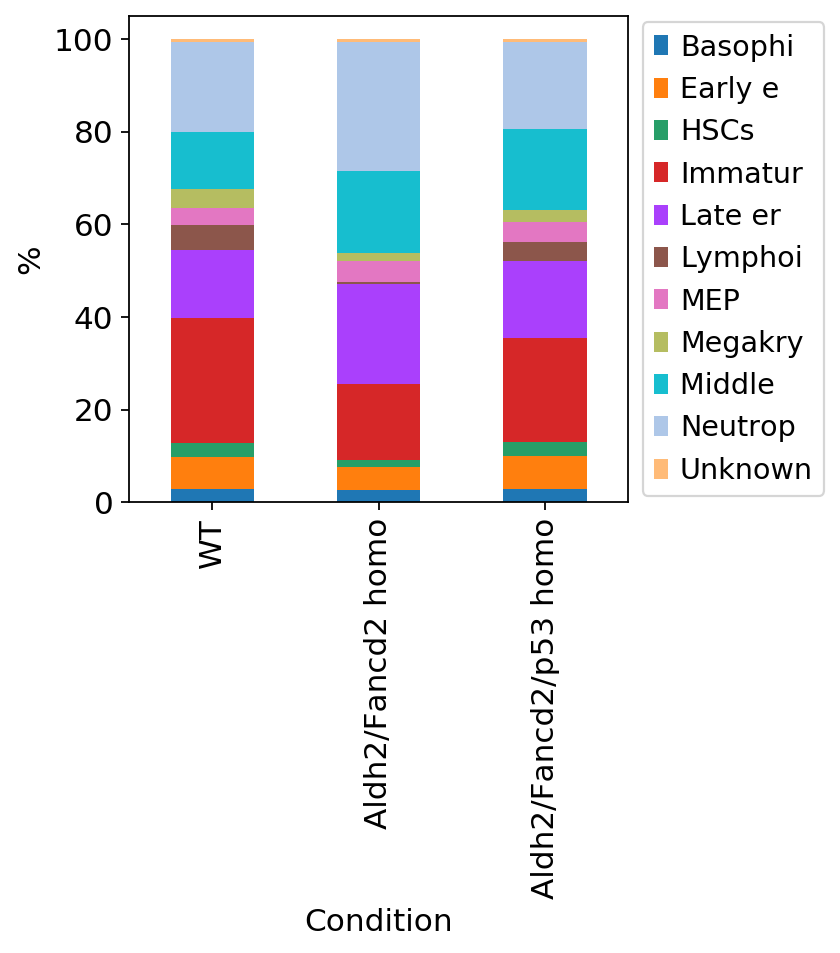

In [61]:
ax = tab1.plot.bar(stacked=True)
ax.grid(False)
ax.set_ylabel('%')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [58]:
Rstore.to_csv('Proj_results.csv')